In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd
import cvxpy as cp


In [3]:
premiumkey = 'D6W40P80TZPAE9QB'

In [10]:
#if i want to include SMA/stock data for same company, need to scrape function not just symbol
def TimeSeriesDaily_df(stock_name):
    """
    Read a CSV file from a URL and return a DataFrame with symbol as the last column.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock_name}&outputsize=full&apikey={premiumkey}&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [56]:
def get_daily_prices(portfolio):
    """
    Returns an array of aligned adjusted close prices for the given portfolio,
    and a percentage change array.
    """
    data = {}

    for s in portfolio:
        df = TimeSeriesDaily_df(s)
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Filter by date
        df = df[df['timestamp'].dt.date > pd.Timestamp('2020-10-04').date()]

        # Set timestamp as index and sort
        prices = df.set_index('timestamp')['adjusted_close'].sort_index()
        data[s] = prices

    # Align all time series on common timestamps
    df_combined = pd.concat(data.values(), axis=1, join='inner')
    df_combined.columns = data.keys()  # Set column names to symbols
    df_combined = df_combined.sort_index()  # Ensure ascending time order

    # Add mean across portfolio
    df_combined['mean'] = df_combined.mean(axis=1)

    # Convert to array (shape: (assets+1, time))
    price_arr = df_combined.to_numpy().T

    # Compute percent change (exclude 'mean' row for return calculation)
    return_arr = (price_arr[:, 1:] - price_arr[:, :-1]) / price_arr[:, :-1] * 100

    return price_arr, return_arr


In [57]:
portfolio_daily = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NDAQ']
portfolio = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']

In [58]:
daily_data, daily_chg_data = get_daily_prices(portfolio_daily)

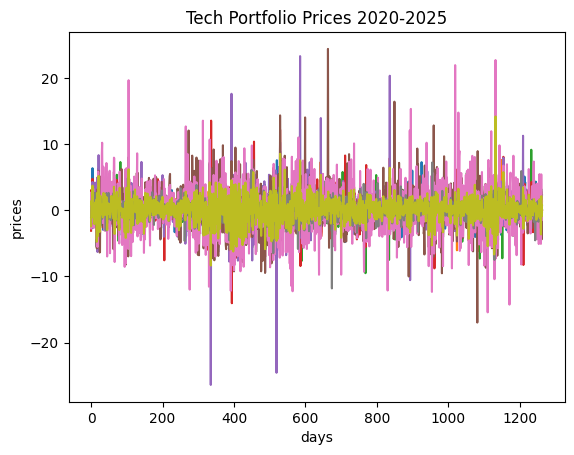

In [59]:
for s in daily_chg_data:
    plt.plot(s)
plt.title('Tech Portfolio Prices 2020-2025')
plt.ylabel('prices')
plt.xlabel('days')
plt.show()

In [11]:
def predict_price(M1, M2, l):
    ''' 
    Uses Koopman related DMD algorithm to predict future prices.
    l is the number of days in the future to predict
    ''' 
    U, s, Vt = np.linalg.svd(M1, full_matrices=False)
    Sigma_inv = np.diag(1.0/s)
    A_tilde = U.T @ M2 @ Vt.T @ Sigma_inv
    evals, evecs = np.linalg.eig(A_tilde)
    Phi = U @ evecs
    x0 = M1[:, 0].reshape((-1,1))
    b = np.linalg.pinv(Phi) @ x0

    n, r = Phi.shape
    preds = np.zeros((n, l))
    for t in range(1, l+1):
        D = np.diag(np.exp(np.log(evals) * t))
        x_t = Phi @ D @ b
        preds[:, t-1] = x_t.ravel().real
    
    return preds

In [12]:
def directional_accuracy(prediction, actual):
    '''
    Returns the accuracy of the predictions. The model is accurate if
    the predicted direction of the price change matches the actual direction.
    '''
    if prediction.shape != actual.shape:
        raise ValueError("Prediction and actual arrays must have the same shape.")

    diff_pred = prediction[:, 1:] - prediction[:, :-1]  
    diff_act = actual[:, 1:] - actual[:, :-1]     
    
    correct = np.sum((diff_pred * diff_act) > 0)
    return correct/diff_pred.size
    

In [13]:
def concat_data(accum, new_data):
    """
    Concatenate new_preds horizontally row by row to accum.
    Handles mixed dtypes by upcasting to object (or str if needed).
    """
    if accum is None:  
        return new_data.astype(object)

    accum = np.asarray(accum, dtype=object)
    new_data = np.asarray(new_data, dtype=object)

    return np.hstack((accum, new_data))

In [14]:
def find_hotspot(data_arr, m_start, m_end, l_start, l_end):
    ''' 
    Finds potential hotspots based on the directional accuracy of price predictions. 
    Uses past 100 days of data to run through a range of parameters (m, l) to find
    combinations that yield an accuracy greater than 0.53.

    Returns a list of tuples (m, l, accuracy) for all combinations tested.
    '''
    accuracy_scores = []
    potential_hotspots = []
    preds_array = []
    actuals_array = []
    hotspots = []
    scores = []
    averages = []

    for m in range(m_start, m_end):
        scores_m_temp = []
        for l in range(l_start, l_end):
            scores_l_temp = []
            predictions = None
            actuals = None

            for t in range(m, data_arr.shape[1]-l, l): 
                M = data_arr[:, t-m:t]
                M1 = M[:, :-1]
                M2 = M[:, 1:]
                preds = predict_price(M1, M2, l) 
                actual = data_arr[:, t:t+l]
                scores_l_temp.append(directional_accuracy(preds, actual))
                predictions = concat_data(predictions, preds)
                actuals = concat_data(actuals, actual)
            preds_array.append(predictions)
            actuals_array.append(actuals)
            accuracy = np.sum(scores_l_temp) / len(scores_l_temp) #the mean of all accuracy scores for a given (m, l)
            accuracy_scores.append((m, l, accuracy))
            scores_m_temp.append(accuracy)
            if accuracy > 0.52: #arbitrary threshold
                potential_hotspots.append((m, l, accuracy))
        scores.append(scores_m_temp)
    
    for m1, l1, acc in potential_hotspots:
        if (m1 == m_start) or (m1 == m_end-1) or (l1 == l_start) or (l1 == l_end-1):
            continue
        idx_m = m1 - m_start
        idx_l = l1 - l_start
        assert(acc == scores[idx_m][idx_l]), 'Wrong indexing for potential hotspot'
        avg = (scores[idx_m-1][idx_l-1] + scores[idx_m-1][idx_l] + scores[idx_m-1][idx_l+1] +
               scores[idx_m][idx_l-1] + scores[idx_m][idx_l] + scores[idx_m][idx_l+1] +
               scores[idx_m+1][idx_l-1] + scores[idx_m+1][idx_l] + scores[idx_m+1][idx_l+1]) / 9
        averages.append(avg)
        if avg * 100 > 50.5:
            hotspots.append((m1, l1, acc, avg))
    
    sorted_hotspots = sorted(hotspots, key=lambda x: x[3], reverse=True) #x[2] to sort by individual acc score; x[3] to sort by average of neighbors acc scores

    return scores, potential_hotspots, sorted_hotspots, preds_array, actuals_array, accuracy_scores, averages

In [15]:
data_arr = daily_data
m_start, m_end = 4, 30
l_start, l_end = 2, 10
data_arr_samp = data_arr #[:, 1200:1450]  # Assuming 252 trading days per year

In [16]:
scores, potential_hotspots, hotspots, preds_array, actuals_array, accuracy_scores, averages = find_hotspot(data_arr_samp, m_start, m_end, l_start, l_end)

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_21195/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


In [17]:
len(potential_hotspots)

4

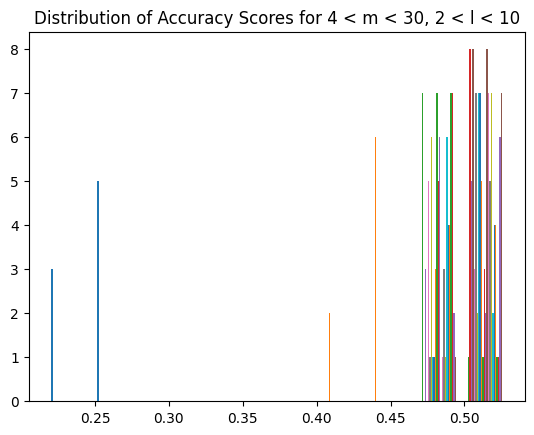

In [18]:
plt.hist(scores)
plt.title(f'Distribution of Accuracy Scores for {m_start} < m < {m_end}, {l_start} < l < {l_end}')
plt.show()

In [19]:
sorted_potential_hotspots = sorted(potential_hotspots, key=lambda x: x[2], reverse=True)
print("Top 5 potential hotspots:")
sorted_potential_hotspots[:5]

Top 5 potential hotspots:


[(9, 2, np.float64(0.5286195286195287)),
 (9, 6, np.float64(0.5235513024986709)),
 (20, 4, np.float64(0.5224611708482676)),
 (9, 3, np.float64(0.5223285486443381))]

In [20]:
hotspots

[(9, 3, np.float64(0.5223285486443381), np.float64(0.506156895598092))]

In [21]:
def get_preds_and_actuals(m, l, m_start, l_start, l_end, preds, actuals, stock_num):
    ''' 
    Get my prediction values and the actual values, and plot them
    Args: 
        m: past days
        l: prediction horizon
        preds: preds_array from find_hospots
        actuals: actuals_array from find_hotspots
        stock_num (int): specific stock i want to see listed in portfolio
    '''
    diff = l_end - l_start
    idx = ((m - m_start) * diff) + (l - l_start)
    p, a = preds[idx][stock_num], actuals[idx][stock_num]

    plt.plot(p, color='blue', label='preds')
    plt.plot(a, color='red', label='actual')
    plt.title(f'Prediction vs. Actual Prices m={m}, l={l}, stock={portfolio[stock_num]}')
    plt.legend()
    plt.show()

    return preds[idx], actuals[idx]
    

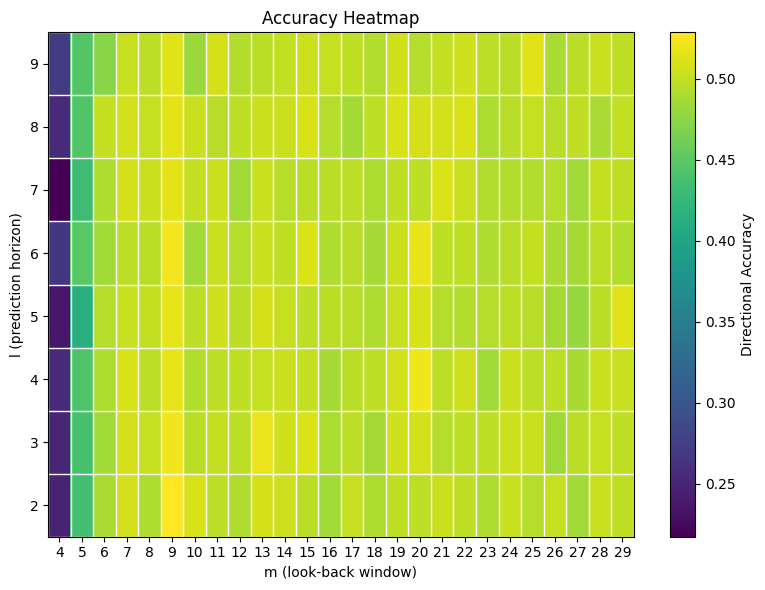

In [22]:
ms = sorted({m for m, l, score in accuracy_scores})
ls = sorted({l for m, l, score in accuracy_scores})

heatmap = np.zeros((len(ls), len(ms)))

for (m_val, l_val, score) in accuracy_scores:
    i = ls.index(l_val)   
    j = ms.index(m_val) 
    heatmap[i, j] = score

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, origin='lower', aspect='auto')

ax.set_xticks(np.arange(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticks(np.arange(len(ls)))
ax.set_yticklabels(ls)

ax.set_xticks(np.arange(len(ms) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(ls) + 1) - 0.5, minor=True)

ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlabel('m (look-back window)')
ax.set_ylabel('l (prediction horizon)')
ax.set_title('Accuracy Heatmap')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Directional Accuracy')

plt.tight_layout()
plt.show()

In [23]:
sorted_potential_hotspots = sorted(potential_hotspots, key=lambda x: x[2], reverse=True)
print("Top 5 potential hotspots:")
sorted_potential_hotspots[:5]

Top 5 potential hotspots:


[(9, 2, np.float64(0.5286195286195287)),
 (9, 6, np.float64(0.5235513024986709)),
 (20, 4, np.float64(0.5224611708482676)),
 (9, 3, np.float64(0.5223285486443381))]

In [24]:
print(f'hotspots: \n {hotspots}')

hotspots: 
 [(9, 3, np.float64(0.5223285486443381), np.float64(0.506156895598092))]


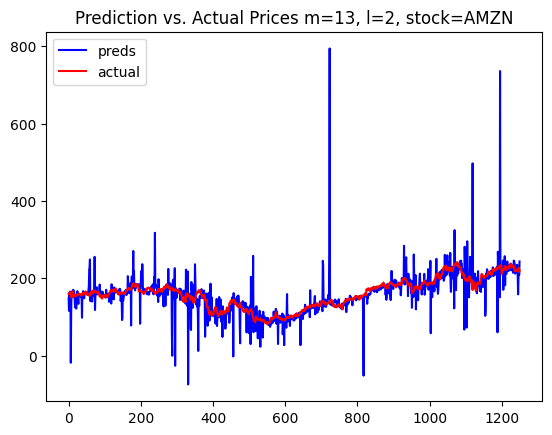

In [25]:
preds, actuals = get_preds_and_actuals(13, 2, m_start, l_start, l_end, preds_array, actuals_array, 3)

In [1]:
def plot_pnl(trade_log):
    """
    Plots cumulative PnL over time based on the trade log.
    
    Arguments:
        trade_log (list of dict): Output from simulate_pnl(), each dict contains 'entry_day' and 'pnl'
    """
    if not trade_log:
        print("No trades to plot.")
        return

    days = []
    pnl_cumsum = []
    running_total = 0.0

    for trade in trade_log:
        days.append(trade["exit_day"])
        running_total += trade["pnl"]
        pnl_cumsum.append(running_total)

    plt.plot(days, pnl_cumsum, marker='o', markersize=3, linestyle='-')
    plt.xlabel("Trading Day")
    plt.ylabel("Cumulative PnL ($)")
    plt.title("Cumulative PnL Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [35]:
def simulate_static_strategy_daily_trading(
    bankroll, data_arr, window_len, step_n, m_start, m_end, l_start, l_end
):
    """
    Strategy: Select best (m, l) hotspot every step_n days.
    For each hotspot:
        - Predict the next l days of prices
        - Each day, place a 1-day trade based on predicted direction (up/down)
        - Repeat every step_n days

    Parameters:
        bankroll (float): Total capital to invest.
        data_arr (np.ndarray): Shape [n_stocks+1, n_days], includes mean row.
        window_len (int): Historical window length for hotspot search.
        step_n (int): Frequency of hotspot re-selection (in days).
        m_start, m_end: Range for m values.
        l_start, l_end: Range for l values.

    Returns:
        total_pnl (float): Accumulated PnL.
        trade_log (list): Trade-by-trade log.
    """
    n_stocks = data_arr.shape[0] - 1
    total_days = data_arr.shape[1]
    day = window_len
    total_pnl = 0.0
    trade_log = []

    while day + step_n < total_days:
        # 1. Select best hotspot from historical window
        train_data = data_arr[:, day - window_len: day]
        _, _, hotspots, _, _, _, _ = find_hotspot(
            train_data, m_start, m_end, l_start, l_end
        )

        if not hotspots:
            day += step_n
            continue

        # 2. Pick best hotspot by accuracy
        m, l, acc, avg = max(hotspots, key=lambda x: x[2])

        # 3. Trade every day using (m, l)
        for t in range(day, day + step_n):
            if t - m < 0 or t + l >= total_days:
                continue

            # Create the prediction for t -> t+l
            M = data_arr[:n_stocks, t - m: t]
            M1 = M[:, :-1]
            M2 = M[:, 1:]
            pred = predict_price(M1, M2, l)

            actual = data_arr[:n_stocks, t: t + l + 1]  # includes day t + l

            for i in range(l-1):  # make l one-day trades: t+i -> t+i+1
                if t + i + 1 >= total_days:
                    break

                valid_idx = (
                    ~np.isnan(pred[:, i]) &
                    ~np.isnan(pred[:, i + 1]) &
                    ~np.isnan(actual[:, i]) &
                    ~np.isnan(actual[:, i + 1])
                )

                if not np.any(valid_idx):
                    continue

                delta = pred[valid_idx, i + 1] - pred[valid_idx, i]
                direction = np.sign(delta)
                if np.all(direction == 0):
                    continue

                entry_prices = actual[valid_idx, i]
                exit_prices = actual[valid_idx, i + 1]

                per_stock_investment = bankroll / len(entry_prices)
                pnl = 0.0

                for j in range(len(entry_prices)):
                    entry = entry_prices[j]
                    exit_ = exit_prices[j]
                    dir_j = direction[j]
                    if dir_j == 0:
                        continue
                    stock_return = (exit_ - entry) if dir_j > 0 else (entry - exit_)
                    pnl += stock_return / entry * per_stock_investment

                total_pnl += pnl
                trade_log.append({
                    "entry_day": t + i,
                    "exit_day": t + i + 1,
                    "m": m,
                    "l": l,
                    "accuracy": acc,
                    "avg_neighbor_accuracy": avg,
                    "pnl": pnl,
                })

        # 4. Advance to next hotspot selection
        day += step_n

    return total_pnl, trade_log, (total_days - window_len)


/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_21195/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


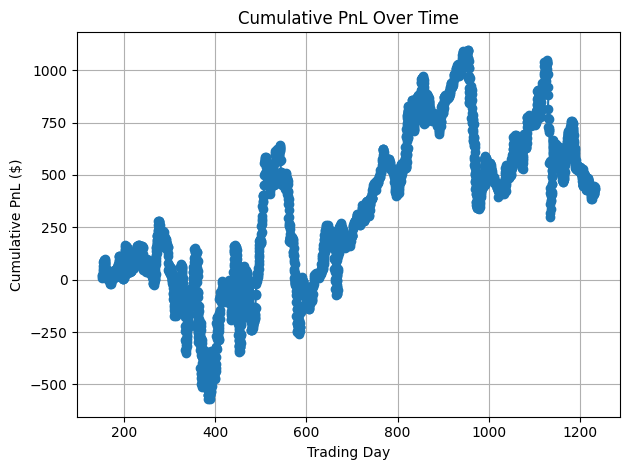

In [36]:
training_window = 150
test_window = 40
static_pnl, static_trades, available_trading_days = simulate_static_strategy_daily_trading(
    bankroll=1000,
    data_arr=data_arr_samp,
    window_len=training_window, #test different window_len
    step_n=test_window, #test different step_n
    m_start=5,
    m_end=30,
    l_start=2,
    l_end=10
)

plot_pnl(static_trades)


In [37]:
print(f'Train Window: {training_window}')
print(f'Test Window: {test_window:.2f}')
print(f'Static PnL: {static_pnl:.2f}')
print(f'Total Trades: {len(static_trades)}')


Train Window: 150
Test Window: 40.00
Static PnL: 441.36
Total Trades: 4320


In [38]:
pnl = [trade['pnl'] for trade in static_trades]
np.var(pnl)

np.float64(199.49300494385523)

In [40]:
def optimal_allocation(expected_returns, cov_matrix, risk_aversion=1.0):
    """
    Mean-variance optimal allocation.

    Parameters:
        expected_returns (np.ndarray): Shape [n], predicted daily returns.
        cov_matrix (np.ndarray): Shape [n, n], estimated covariance of returns.
        risk_aversion (float): Lambda, trade-off between return and variance.

    Returns:
        np.ndarray: Optimal weights summing to 1.
    """
    n = len(expected_returns)
    w = cp.Variable(n)

    objective = cp.Maximize(w @ expected_returns - risk_aversion * cp.quad_form(w, cov_matrix))
    constraints = [cp.sum(w) == 1, w >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is not None:
        return np.array(w.value)
    else:
        return np.ones(n) / n  # fallback: equal allocation
